# RL Policy Training - SAC

Train SAC (Soft Actor-Critic) with continuous action space to learn service policies.

Key differences from DQN:
- Continuous action space: agent outputs delay directly [0, max_delay]
- Off-policy (like DQN) - efficient replay buffer usage
- Entropy regularisation - helps exploration in noisy environments

**Optional variance reduction:** If `discretiser-surrogate` is installed, can use `MultiSampleServiceEnv` which samples multiple failure outcomes per step, reducing gradient variance by O(1/n).

See also:
- `rl_quickstart.ipynb` - Minimal example (runnable by anyone)
- `rl_dqn.ipynb` - DQN with discrete action space

In [ ]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from src.rl import (
    ServiceEnv,
    get_default_scenario,
    print_scenario_info,
    compare_with_baselines,
    run_sanity_check,
    evaluate_model,
    print_evaluation_results,
    format_stats,
    RewardLoggerCallback,
    EpisodeDiagnosticsCallback,
    ContinuousActionStatsCallback,
    DEFAULT_MAX_TIME,
)

# Optional: variance-reduced environment from discretiser-surrogate
try:
    from discretiser_surrogate import MultiSampleServiceEnv, SurvivalFractionCallback
    HAS_SURROGATE = True
    print("discretiser-surrogate available: MultiSampleServiceEnv, SurvivalFractionCallback")
except ImportError:
    HAS_SURROGATE = False
    print("discretiser-surrogate not installed, using standard ServiceEnv")

## 1. Setup Scenario

In [2]:
# Use shared scenario setup
scenario = get_default_scenario()
print_scenario_info(scenario)

MAX_TIME = DEFAULT_MAX_TIME

# ============================================================
# KEY CONFIG
# ============================================================
FIXED_DURABILITY = 1.0  # None = variable, 1.0 = fixed for debugging
MAX_ACTION_DELAY = 100.0

# Variance reduction via multi-sample environment (requires discretiser-surrogate)
USE_VARIANCE_REDUCTION = HAS_SURROGATE and True  # Set to False to disable even if available
N_SAMPLES = 10  # Number of failure samples per step (only if USE_VARIANCE_REDUCTION)

print(f"\nDurability config: {'FIXED at ' + str(FIXED_DURABILITY) if FIXED_DURABILITY else 'VARIABLE'}")
print(f"Variance reduction: {'ENABLED (n_samples={N_SAMPLES})' if USE_VARIANCE_REDUCTION else 'DISABLED'}")

Scenario parameters:
  Bathtub shape: shape1=0.5, shape2=3.0
  Scales: scale1=100.0, scale2=200.0
  Delta_t (age reduction per service): 15.0
  Costs: service=0.5, failure=150.0
  Revenue per time: 1.5

Durability config: FIXED at 1.0
Variance reduction: ENABLED (n_samples={N_SAMPLES})


## 2. Baseline Comparison

In [ ]:
# Compare baseline policies (always uses variable durability)
results = compare_with_baselines(scenario, max_time=MAX_TIME, n_repeats=500)

if FIXED_DURABILITY is not None:
    print(f"\nNote: Baselines above use variable durability.")
    print(f"      Training uses fixed durability={FIXED_DURABILITY} - see sanity check for proper baseline.")

Baseline Policy Comparison
optimised_linear    : mean=  -26.08 +/-   3.00
fixed_50            : mean=  -26.85 +/-   3.04
no_service          : mean=  -29.84 +/-   3.16
linear_15_10        : mean=  -32.50 +/-   3.04
fixed_25            : mean=  -32.97 +/-   3.03

Note: Baselines above use variable durability.
      Training uses fixed durability=1.0 - see sanity check for proper baseline.


In [30]:
# Sanity check: Run optimal policy through RL environment
# Uses same FIXED_DURABILITY as training config
sanity_results = run_sanity_check(scenario, max_time=MAX_TIME, fixed_durability=FIXED_DURABILITY, n_episodes=5000)

if FIXED_DURABILITY is None:
    print(f"\nExpected: Should match 'optimised_linear' baseline (~{results['optimised_linear']['mean']:.2f})")
else:
    print(f"\nThis is the proper baseline for fixed_durability={FIXED_DURABILITY}")

Sanity check: Optimal policy through RL environment
Optimal policy (a=24.2, b=24.2, durability=1.0 -> interval=48.4):
  Mean reward (original): -23.41 +/- 138.67
  Mean episode time: 64.0
  Truncated (survived): 1037/5000

This is the proper baseline for fixed_durability=1.0


## 3. Train SAC

SAC uses continuous action space - the agent outputs the delay directly.

In [5]:
# Train SAC
import torch.nn as nn
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback

# Environment settings (FIXED_DURABILITY and MAX_ACTION_DELAY defined in cell 3)
REWARD_SCALE = None       # None = use failure_cost (rewards in ~[0, 2.5])

# SAC hyperparameters
LEARNING_RATE = 3e-4
BATCH_SIZE = 8*256          # SAC typically uses smaller batches than DQN needed
GAMMA = 0.99
TAU = 0.001 # 0.005               # Soft update coefficient (SAC default)
BUFFER_SIZE = 50_000

# Entropy coefficient (auto-tuned by default)
ENT_COEF = 'auto'         # Or set to fixed value like 0.1

# Checkpointing
SAVE_CHECKPOINTS = True
CHECKPOINT_FREQ = 10_000

# Create training environment
if USE_VARIANCE_REDUCTION:
    # Variance-reduced environment (multi-sample)
    env = MultiSampleServiceEnv(
        scenario,
        n_samples=N_SAMPLES,
        max_time=MAX_TIME,
        seed=42,
        max_action_delay=MAX_ACTION_DELAY,
        fixed_durability=FIXED_DURABILITY,
        # continuous_actions=True is forced by MultiSampleServiceEnv
    )
    print(f"Using MultiSampleServiceEnv with n_samples={N_SAMPLES}")
else:
    # Standard environment
    env = ServiceEnv(
        scenario, 
        max_time=MAX_TIME, 
        seed=42,
        reward_scale=REWARD_SCALE,
        max_action_delay=MAX_ACTION_DELAY,
        fixed_durability=FIXED_DURABILITY,
        continuous_actions=True,
    )
    print("Using standard ServiceEnv")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Reward scale: {env.reward_scale}")
print(f"Fixed durability: {FIXED_DURABILITY}")

# Optimal interval for durability=1.0: 24.2 + 24.2*1.0 = 48.4
if FIXED_DURABILITY is not None:
    opt_interval = 24.2 + 24.2 * FIXED_DURABILITY
    print(f"Optimal interval (from linear policy): {opt_interval:.1f}")
else:
    print("Optimal interval varies: 24.2 + 24.2 * durability")

# Create evaluation environments (always use standard env for fair comparison)
eval_env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=123,
    max_action_delay=MAX_ACTION_DELAY, fixed_durability=FIXED_DURABILITY,
    continuous_actions=True,
)
optimal_env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=123,
    max_action_delay=MAX_ACTION_DELAY, fixed_durability=FIXED_DURABILITY,
    continuous_actions=True,
    use_optimal_policy=True,
)

# Wrap training env for logging
env = Monitor(env)

# Network architecture
policy_kwargs = dict(
    net_arch=[64, 64],
    activation_fn=nn.Tanh,#   nn.ReLU,
)

# Print configuration
print(f"\nSAC Configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Soft update tau: {TAU}")
print(f"  Entropy coef: {ENT_COEF}")
print(f"  Network: {policy_kwargs}")

# TensorBoard: run `tensorboard --logdir ./logs` to watch
print("\nTraining SAC (verbose=0, use TensorBoard to monitor)...")

model = SAC(
    'MlpPolicy',
    env,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    tau=TAU,
    ent_coef=ENT_COEF,
    policy_kwargs=policy_kwargs,
    verbose=0,
    seed=42,
    tensorboard_log="./logs",
)

# Callbacks for logging
reward_logger = RewardLoggerCallback()
callbacks = [
    reward_logger,
    ContinuousActionStatsCallback(log_freq=1000),
    EpisodeDiagnosticsCallback(
        max_time=MAX_TIME,
        log_freq=100,
        eval_env=eval_env,
        optimal_env=optimal_env,
        n_eval_episodes=50,
    ),
]

# Add survival fraction callback if using variance reduction
if USE_VARIANCE_REDUCTION:
    callbacks.append(SurvivalFractionCallback(log_freq=100))
    print("  Added SurvivalFractionCallback for variance reduction monitoring")

# Optional: Save checkpoints during training
if SAVE_CHECKPOINTS:
    checkpoint_callback = CheckpointCallback(
        save_freq=CHECKPOINT_FREQ,
        save_path='./checkpoints/',
        name_prefix='sac_service',
    )
    callbacks.append(checkpoint_callback)
    print(f"  Checkpoints: every {CHECKPOINT_FREQ} steps to ./checkpoints/")

model.learn(total_timesteps=200_000, callback=callbacks)

# Store for later cells
training_rewards = reward_logger.episode_rewards
trained_model = model

print(f"\nTraining complete!")
print(f"Episodes: {len(training_rewards)}")

Using MultiSampleServiceEnv with n_samples=10
Action space: Box(0.0, 100.0, (1,), float32)
Observation space: Box(0.0, 1.0, (5,), float32)
Reward scale: 150.0
Fixed durability: 1.0
Optimal interval (from linear policy): 48.4

SAC Configuration:
  Learning rate: 0.0003
  Batch size: 2048
  Soft update tau: 0.001
  Entropy coef: auto
  Network: {'net_arch': [64, 64], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>}

Training SAC (verbose=0, use TensorBoard to monitor)...
  Added SurvivalFractionCallback for variance reduction monitoring
  Checkpoints: every 10000 steps to ./checkpoints/

Training complete!
Episodes: 87288


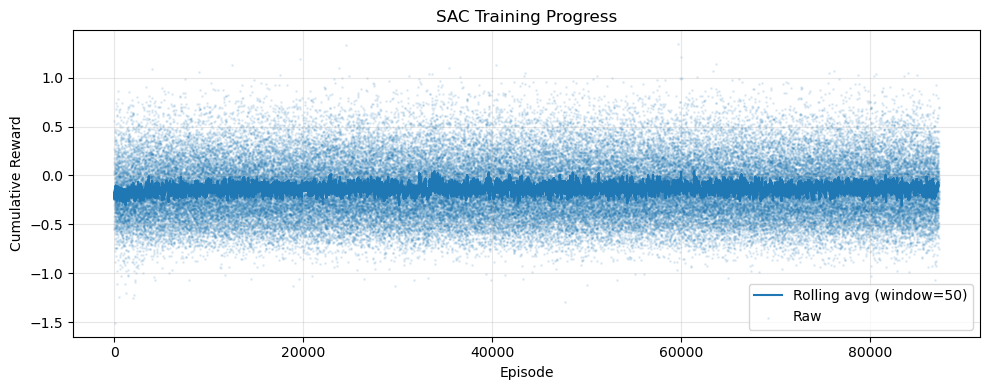

In [26]:
# Plot training progress
fig, ax = plt.subplots(figsize=(10, 4))

rewards = training_rewards
window = 50
if len(rewards) > window:
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax.plot(smoothed, label=f'Rolling avg (window={window})')
    ax.scatter(range(len(rewards)), rewards, alpha=0.1, s=1, label='Raw')
else:
    ax.plot(rewards)

ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Reward')
ax.set_title('SAC Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Evaluate Trained Model

In [ ]:
# Evaluate trained SAC model
sac_results = evaluate_model(
    trained_model,
    scenario,
    n_episodes=5000,
    max_time=MAX_TIME,
    seed=42,
    deterministic=True,
    max_action_delay=MAX_ACTION_DELAY,
    fixed_durability=FIXED_DURABILITY,
    continuous_actions=True,
)

print_evaluation_results(sac_results, "SAC", show_minmax=True)

In [ ]:
# Compare SAC vs baselines
fig, ax = plt.subplots(figsize=(10, 5))

all_results = {name: stats['mean'] for name, stats in results.items()}
all_results['SAC'] = np.mean(sac_results['rewards'])

# Add sanity check (optimal policy with same durability config)
if FIXED_DURABILITY is not None:
    all_results['optimal (fixed d)'] = np.mean(sanity_results['rewards'])

sorted_results = sorted(all_results.items(), key=lambda x: x[1])
names = [r[0] for r in sorted_results]
means = [r[1] for r in sorted_results]

colors = ['green' if n == 'SAC' else 'orange' if 'optimal' in n else 'steelblue' for n in names]
bars = ax.barh(names, means, color=colors)

ax.set_xlabel('Mean Reward')
title = 'SAC vs Baselines'
if FIXED_DURABILITY is not None:
    title += f' (fixed durability={FIXED_DURABILITY})'
ax.set_title(title)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

for bar, mean in zip(bars, means):
    ax.text(mean + 5, bar.get_y() + bar.get_height()/2, 
            f'{mean:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

if FIXED_DURABILITY is not None:
    print(f"\nNote: 'optimal (fixed d)' uses same fixed_durability={FIXED_DURABILITY} as SAC.")
    print(f"      Other baselines use variable durability (not directly comparable).")

## 5. Analyse SAC Behaviour

In [21]:
# Analyse action (delay) distribution across different states
import pandas as pd

env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=42,
    max_action_delay=MAX_ACTION_DELAY,
    fixed_durability=FIXED_DURABILITY,  # Match training config
    continuous_actions=True,
)

state_actions = []
for ep in range(100):
    obs, _ = env.reset(seed=42 + ep)
    done = False
    while not done:
        action, _ = trained_model.predict(obs, deterministic=True)
        delay = float(action[0])  # Continuous action is the delay directly
        state_actions.append({
            'current_time': obs[0] * MAX_TIME,
            'last_interval': obs[1] * MAX_TIME,
            'service_count': obs[2] * 100,
            'avg_interval': obs[3] * MAX_TIME,
            'durability': obs[4] * 10,
            'delay': delay
        })
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

df = pd.DataFrame(state_actions)

print("Delay statistics:")
print(f"  Mean: {df['delay'].mean():.1f}")
print(f"  Std:  {df['delay'].std():.1f}")
print(f"  Min:  {df['delay'].min():.1f}")
print(f"  Max:  {df['delay'].max():.1f}")
print(f"\nTotal decisions: {len(df)}")

# Optimal: 24.2 + 24.2 * 1.0 = 48.4 for durability=1.0
if FIXED_DURABILITY is not None:
    print(f"\nOptimal delay for durability={FIXED_DURABILITY}: {24.2 + 24.2 * FIXED_DURABILITY:.1f}")
else:
    print("\nOptimal delay varies with durability: 24.2 + 24.2 * durability")

Delay statistics:
  Mean: 40.5
  Std:  31.4
  Min:  4.8
  Max:  78.6

Total decisions: 254

Optimal delay for durability=1.0: 48.4


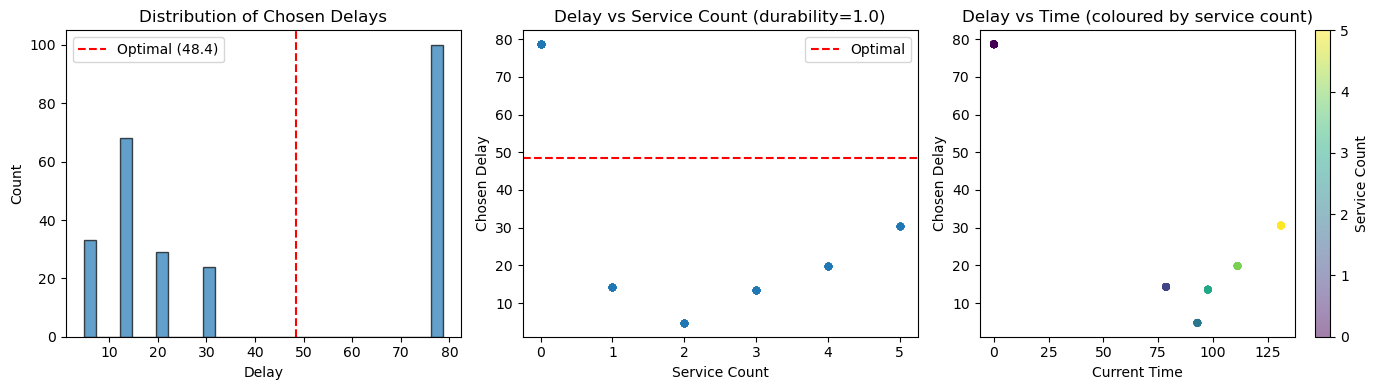

In [22]:
# Plot delay distribution and relationships
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histogram of delays
ax = axes[0]
ax.hist(df['delay'], bins=30, edgecolor='black', alpha=0.7)
if FIXED_DURABILITY is not None:
    opt_delay = 24.2 + 24.2 * FIXED_DURABILITY
    ax.axvline(opt_delay, color='red', linestyle='--', label=f'Optimal ({opt_delay:.1f})')
ax.set_xlabel('Delay')
ax.set_ylabel('Count')
ax.set_title('Distribution of Chosen Delays')
ax.legend()

# Delay vs durability (only meaningful if durability varies)
ax = axes[1]
if FIXED_DURABILITY is not None:
    # With fixed durability, show delay vs service_count instead
    ax.scatter(df['service_count'], df['delay'], alpha=0.5, s=20)
    ax.axhline(24.2 + 24.2 * FIXED_DURABILITY, color='red', linestyle='--', label='Optimal')
    ax.set_xlabel('Service Count')
    ax.set_ylabel('Chosen Delay')
    ax.set_title(f'Delay vs Service Count (durability={FIXED_DURABILITY})')
    ax.legend()
else:
    ax.scatter(df['durability'], df['delay'], alpha=0.5, s=20)
    # Plot optimal linear policy for reference
    d_range = np.linspace(df['durability'].min(), df['durability'].max(), 50)
    ax.plot(d_range, 24.2 + 24.2 * d_range, 'r--', label='Optimal linear')
    ax.set_xlabel('Durability')
    ax.set_ylabel('Chosen Delay')
    ax.set_title('Delay vs Durability')
    ax.legend()

# Delay vs time
ax = axes[2]
scatter = ax.scatter(df['current_time'], df['delay'], c=df['service_count'], alpha=0.5, s=20, cmap='viridis')
ax.set_xlabel('Current Time')
ax.set_ylabel('Chosen Delay')
ax.set_title('Delay vs Time (coloured by service count)')
plt.colorbar(scatter, ax=ax, label='Service Count')

plt.tight_layout()
plt.show()

## 6. Save Model

In [11]:
# Save trained model
model_path = '../models/sac_service_policy'
trained_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/sac_service_policy
